# Fixed point with noise: compare theory and simulation 
### for $g = 0$. 

In [1]:
# from importlib import reload
import os, time
import numpy as np
from tqdm import tqdm
import pickle
from copy import deepcopy
# from collections import OrderedDict

import torch
use_cuda = True
if torch.cuda.is_available() and use_cuda:
    device = torch.device('cuda')
    print("Use cuda.")
else:
    device = torch.device('cpu')
    print("Use cpu.")
to_dev = lambda arr: (torch.from_numpy(arr).to(device)
                       if type(arr) == np.ndarray else arr.to(device))
# Low-rank RNN model
from rnn_model_dt_low_rank import RNN_Net_lr
from helpers import copy_sd
# Data path
from specs import data_path

# Figures 
from specs import *
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

Use cpu.


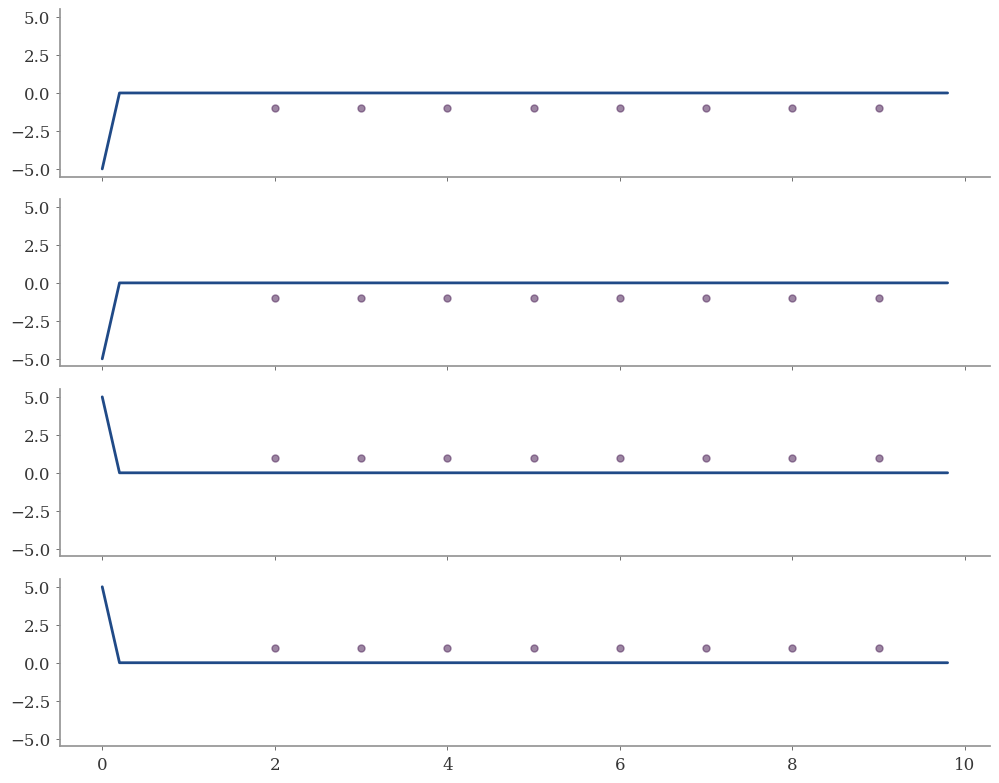

In [2]:
# Choose noise level
large_noise = True
if large_noise:
    # Large noise, faster learning
    sigma_noises = np.array([1.0,])
    lr0 = 0.005
    n_steps = 2000
else:
    # Small noise, slower learning
    sigma_noises = np.array([0.2,])
    lr0 = 0.01
    n_steps = 5000
n_sn = len(sigma_noises)

# Targer amplitude
z_target = 1.

# Hidden dimension
dim_hids = np.array([64, 128, 256, 512, 1024])
n_dim = len(dim_hids)
M_init = torch.Tensor([[0, 0], 
                       [0, 0.]])
n_samples = 1
n_mi = n_samples, n_dim, n_sn

# Network parameters
rank = 2
g = 0
train_in = False
train_hid = True
train_out = False
train_layers = [train_in, train_hid, train_out]
alpha_phi = np.sqrt(np.pi) / 2
nonlin = lambda x: torch.special.erf(alpha_phi * x)
rnn_num_layers = 1
h_0_std = 0.
# Correlation between in and out weights
rho_sqrtN = 0.
# Output scale
out_scale = 'large'
# Noise on input, h_0, and hidden states
noise_input_std = 0.0
noise_init_std = 0.0

# Task
from task_generators import fixed_points as task_generator
n_fp = 1
dim_in = n_fp
dim_out = n_fp
dt = 0.2
rec_step_dt = 1
mask_step_dt = 5
t_max = 10
t_loss_min = 2
target_amp = z_target
batch_size = 32

# Task generators and fixed eval task
task_params = dict(
    t_max=t_max, 
    t_loss_min=t_loss_min,
    target_amp=target_amp, 
    rec_step_dt=rec_step_dt,
    mask_step_dt=mask_step_dt,
)
task_gen = task_generator(dim_in, dim_out, dt, **task_params)
task_params_ev = deepcopy(task_params)
task_gen_ev = task_generator(dim_in, dim_out, dt, **task_params_ev)
ts_ev, input_ev, target_ev, mask_ev = task_gen_ev(batch_size)
n_t_ev = len(ts_ev)

# Plot the task
n_show = min(4, batch_size)
n_cols = 1
n_rows = n_show
fig = plt.figure(figsize=(10, 2 * n_rows))
axes = subplots(fig, n_rows, n_cols, sharey=True, sharex=True)
for i_b in range(n_show):
    ax = axes[i_b, 0]
    # Input
    for i_in in range(dim_in):
        ax.plot(ts_ev, (input_ev)[i_b, :, i_in], "-", c=colors[i_in])
    # Target
    for i_out in range(dim_out):
        c = colors[4]
        m = mask_ev[i_b, :, i_out]
        ax.plot(ts_ev[m], target_ev[i_b, :, i_out][m], 'o', ms=5, c=c, alpha=0.6)

fig.tight_layout()
plt.show()

In [3]:
# Nonlinearity
from scipy.linalg import solve_lyapunov
from scipy.integrate import quad, dblquad
from scipy.optimize import root, root_scalar

nonlin_str = 'erf'
if nonlin_str == 'tanh':
    nonlin = torch.nn.Tanh()
elif nonlin_str == 'erf':
    alpha_phi = np.sqrt(np.pi) / 2
    nonlin = lambda x: torch.special.erf(alpha_phi * x)
    
# Nonlinearity
if nonlin_str == 'tanh':
    phi = lambda x: np.tanh(x)
    dphi = lambda x: 1 - phi(x)**2
    d2phi = lambda x: - 2 * phi(x) * dphi(x)
    d3phi = lambda x: - 2 * (d2phi(x) * phi(x) + dphi(x)**2)
elif nonlin_str == 'erf':
    from scipy.special import erf
    alpha_phi = np.sqrt(np.pi) / 2
    phi = lambda x: erf(alpha_phi * x)
    dphi = lambda x: np.exp(-(alpha_phi * x)**2)
    d2phi = lambda x: -2 * alpha_phi**2 * x * dphi(x)
    d3phi = lambda x: -2 * alpha_phi**2 * (dphi(x) + x * d2phi(x))
    d4phi = lambda x: -2 * alpha_phi**2 * (2 * d2phi(x) + x * d3phi(x))
    d5phi = lambda x: -2 * alpha_phi**2 * (3 * d3phi(x) + x * d4phi(x))
    int_phi = lambda x: x * phi(x) + 2 / np.pi * (dphi(x) - 1)
    int_Dx_Phi = lambda sigma_x: 2 / np.pi * (np.sqrt(1 + 2 * (alpha_phi * sigma_x)**2) - 1)
    def root_sigma_x_no_fp(sigma_x, sigma_noise, g):
        """ State amplitude sigma_x in absence of autonomous low-rank fixed point. """
        if g == 0:
            root_s = -sigma_x + sigma_noise
        elif sigma_noise == 0:
            int_Dx_phi_sq = avg_func(lambda x: phi(x)**2, sigma_x)
            root_s = -sigma_x**2 + g**2 * int_Dx_phi_sq
        else:
            int_Dx_Phi_sq = avg_func(lambda x: int_phi(x)**2, sigma_x)
            root_s = -sigma_x**4 + sigma_noise**4 + 2 * g**2 * (int_Dx_Phi_sq - int_Dx_Phi(sigma_x)**2)
        return root_s
    lam_p_sigma_x = lambda sigma_x: np.sqrt(1 + 2 * (alpha_phi * sigma_x)**2)
    sigma_x_lam_p = lambda lam_p: np.sqrt((lam_p**2 - 1) / 2) / alpha_phi
    
    def avg_Phi_dphi_func(sigma_x):
        return (
            2 / np.pi / np.sqrt(1 + 2 * (alpha_phi * sigma_x)**2) * (
            np.sqrt((1 + 4 * (alpha_phi * sigma_x)**2) / (1 + 2 * (alpha_phi * sigma_x)**2))
            - 1) )
    def f_Phi_dphi_func(c_0, c_inf, kappa_norm):
        return 2 / np.pi * (
        np.sqrt(
        (1 + 2 * alpha_phi**2 * (2 * kappa_norm**2 + c_0 + c_inf))
        * (1 + 2 * alpha_phi**2 * (c_0 - c_inf))
        ) / (1 + 2 * alpha_phi**2 * (kappa_norm**2 + c_0))
        - 
        1 / np.sqrt(1 + 2 * alpha_phi**2 * (kappa_norm**2 + c_0))
    ) 
    
    # Analytical expressions for averages (not very costly anyways...)
    avg_dphi_func = lambda sigma_x: 1 / np.sqrt(1 + 2 * (alpha_phi * sigma_x)**2)
    avg_d3phi_func = lambda sigma_x: -2 * alpha_phi**2 * (1 + 2 * (alpha_phi * sigma_x)**2)**(-3/2)
    avg_dphi_sq_func = lambda sigma_x: 1 / np.sqrt(1 + 4 * (alpha_phi * sigma_x)**2)
    avg_dphi_sq_p_phi_d2phi_func = lambda sigma_x: 1 / (1 + 2 * (alpha_phi * sigma_x)**2 ) * avg_dphi_sq_func(sigma_x)


# Mean field theory functions
# Averages
def avg_func(func, std):
    """ Average 'func' over Gaussian with standard dev. 'std'. """
    pdf = lambda z: np.exp(-z**2/2) / np.sqrt(2 * np.pi)
    return quad(lambda z: pdf(z) * func(std * z), -np.inf, np.inf)[0]
# Predict fixed point variance
def solve_sigma_x(avg_dphi, sigma_x_guess=1):
    x_target = avg_dphi
    func = lambda sigma_x: avg_func(dphi, sigma_x)
    root_log = lambda log_x: -x_target + func(np.exp(log_x))
    sol = root(root_log, x0=np.log(sigma_x_guess), method="hybr")
    if sol["success"]:
        log_sigma_x = sol["x"][0]
        sigma_x = np.exp(log_sigma_x)
        return sigma_x
    else:
        return 0.
    
# Noisy fixed point is shifted.
if nonlin_str == 'erf':
    def avg_dphi_func_root(norm_kappa, sigma_noise):
        return 1 / np.sqrt(1 + np.pi / 2 * (norm_kappa**2 + sigma_noise**2))
else:
    def avg_dphi_func_root(norm_kappa, sigma_noise):
        pdf = lambda z: np.exp(-z**2/2) / np.sqrt(2 * np.pi)
        integrand = lambda u, x: pdf(x) * pdf(u) * dphi(norm_kappa * u + sigma_noise * x)
        return dblquad(integrand, -np.inf, np.inf, lambda x: -np.inf, lambda x: np.inf)[0]
def solve_norm_kappa_noisy(avg_dphi, sigma_noise, norm_kappa_guess=1):
    x_target = avg_dphi
    func = lambda norm_kappa: avg_dphi_func_root(norm_kappa, sigma_noise)
    root_log = lambda log_x: -x_target + func(np.exp(log_x))
    sol = root(root_log, x0=np.log(norm_kappa_guess), method="hybr")
    if sol["success"]:
        log_norm_kappa = sol["x"][0]
        norm_kappa = np.exp(log_norm_kappa)
        return norm_kappa
    else:
        return 0.

# Solve double integral equations numerically
def root_c_0_infty(cs, sigma_x, sigma_noise, g):
    c_0, c_inf = cs
    
    # Integrals
    gamma = 1 / np.sqrt(1 + 2 * alpha_phi**2 * (c_0 - c_inf) / sigma_x**2 * (2 * sigma_x**2 - (c_0 - c_inf)))
    beta = (sigma_x**2 - (c_0 - c_inf)) / sigma_x**2 * gamma
    f_phi_inf_0 = avg_func(
        lambda y: phi(sigma_x * y) * phi(sigma_x * beta * y), 1)
    sigma_hat = 1 / np.sqrt(1 + 2 * (alpha_phi * sigma_x * beta)**2)
    f_Phi_inf_0 = 2 / np.pi * (
        2 * alpha_phi**2 * (sigma_x**2 - (c_0 - c_inf)) * f_phi_inf_0
        + np.sqrt(1 + 2 * (alpha_phi * sigma_x)**2) * int_Dx_Phi(sigma_x * sigma_hat)
        - int_Dx_Phi(sigma_x)
    )
    f_Phi_0_0 = avg_func(lambda y: int_phi(y)**2, sigma_x)

    # Equations
    root_c_inf = -c_inf + g**2 * f_phi_inf_0
    root_c_0 = sigma_noise**4 - (c_0**2 - c_inf**2) + 2 * g**2 * (f_Phi_0_0 - f_Phi_inf_0)
    
    return np.array([root_c_inf, root_c_0])

# Constrain solutions to c_0 in [0, sigma_x**2], c_inf in [0, c_0]
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
def inv_sigmoid(x):
    return np.log(x / (1 - x))
def root_c_0_infty_constr(arg_r_cs, sigma_x, sigma_noise, g):
    """ r_cs should both be in square [0, 1]. Force by using sigmoid. """
    r_cs = sigmoid(arg_r_cs)
    r_c_0, r_c_inf = r_cs
    c_0 = r_c_0 * sigma_x**2
    c_inf = r_c_inf * c_0
    cs = np.array([c_0, c_inf])
    return root_c_0_infty(cs, sigma_x, sigma_noise, g)
def solve_c_0_infty(sigma_x, sigma_noise, g, cs_init, c_0_min=0):
    if g == 0:
        cs = np.array([sigma_noise**2, 0.])
    elif sigma_noise == 0:
        c_0 = g**2 * avg_func(lambda x: phi(x)**2, sigma_x)
        cs = np.array([c_0, c_0])
    else:
        # Ratios in [0, 1]
        c_0, c_inf = cs_init

        c_0_max = sigma_x**2
        dc_0 = c_0_max - c_0_min
        assert c_0 >= c_0_min, "Initial guess too small for c_0"
        assert c_0 <= c_0_max, "Initial guess too large for c_0"
        r_c_0 = (c_0 - c_0_min) / dc_0

        c_inf_min = 0
        c_inf_max = c_0
        dc_inf = c_inf_max - c_inf_min
        assert c_inf >= c_inf_min, "Initial guess too small for c_inf"
        assert c_inf <= c_inf_max, "Initial guess too large for c_inf"
        r_c_inf = (c_inf - c_inf_min) / dc_inf

        r_cs_init = np.array([r_c_0, r_c_inf])
        # Expand to -oo, oo
        arg_r_cs_init = inv_sigmoid(r_cs_init)
        # Solve
        sol = root(root_c_0_infty_constr, x0=arg_r_cs_init, args=(sigma_x, sigma_noise, g), )
        if sol["success"]:
            arg_r_cs = sol["x"]
            r_cs = sigmoid(arg_r_cs)
            c_0 = r_cs[0] * dc_0 + c_0_min
            c_inf = r_cs[1] * dc_inf + c_inf_min
            cs = np.array([c_0, c_inf])
        else:
            cs = np.ones(2) * np.nan
    return cs

# Matrix M from EVs and angles
rank = 2
Id = np.eye(rank)
def comp_M(lam_p, lam_m, ang_wp, ang_wm, to_torch=False):
    """ Matrix from 4 arguments. Both angles relative to output w. """
    V = np.array([
        [np.cos(ang_wp), np.cos(ang_wm)],
        [np.sin(ang_wp), np.sin(ang_wm)],
        ])
    M = V @ np.diag(np.array([lam_p, lam_m])) @ np.linalg.inv(V)
    if to_torch:
        M = torch.from_numpy(np.float32(M))
        V = torch.from_numpy(np.float32(V))
    return M, V


def comp_MFT(lam_p, sigma_noise, g, cs_init=None):
    """ Compute Mean Field Theory prediction for given lam_p, sigma_noise, g.
    """
    # Critical EV
    sigma_x_crit_min = sigma_noise if g <= 1 else sigma_noise + 1e-5
    sigma_x_crit = root_scalar(root_sigma_x_no_fp, method='bisect', args=(sigma_noise, g), bracket=[sigma_x_crit_min, 10], x0=1.1).root
    lam_p_crit = lam_p_sigma_x(sigma_x_crit)
    
    # Norm of fixed point is entirely given by outlier
    sigma_x = sigma_x_lam_p(lam_p)
    # Norm of orthogonal component
    c_0_no_noise = g**2 * avg_func(lambda x: phi(x)**2, sigma_x)

    if lam_p > lam_p_crit and c_0_no_noise <= sigma_x**2:
        if cs_init is None:
            c_0_init = 0.5 * sigma_x
            c_inf_init = 0.4 * c_0_init
        else:
            c_0_init, c_inf_init = cs_init
        c_0_min = c_0_no_noise
        c_0_max = sigma_x**2
        c_0_init = max(c_0_init, c_0_min + 1e-3)
        c_0_init = min(c_0_init, c_0_max - 1e-3)
        c_inf_init = min(c_inf_init, sigma_x**2 - 1e-3)
        cs_init = np.array([c_0_init, c_inf_init])

        c_0, c_inf = solve_c_0_infty(sigma_x, sigma_noise, g, cs_init)
        sigma_orth = np.sqrt(c_0)
        AC_inf = c_inf

        # Remaining variance
        kappa_norm = np.sqrt(sigma_x**2 - sigma_orth**2)
    else:
        # No fixed point -> kappa = 0
        sigma_x_max = 2 * (sigma_noise + g)
        sigma_x_min = 0 if g <= 1 else 1e-10
        sigma_x = root_scalar(root_sigma_x_no_fp, method='bisect', args=(sigma_noise, g), bracket=[sigma_x_min, sigma_x_max]).root
        sigma_orth = sigma_x
        kappa_norm = 0
        AC_inf = 0
        
    return sigma_x, sigma_orth, kappa_norm, AC_inf


def comp_MFT_g0(lam_p, sigma_noise):
    """ Compute Mean Field Theory prediction for given lam_p, sigma_noise for g - 0.
    """
    # Critical EV
    sigma_x_crit = sigma_noise
    lam_p_crit = lam_p_sigma_x(sigma_x_crit)
    
    # Norm of fixed point is entirely given by outlier
    sigma_x = sigma_x_lam_p(lam_p)

    if lam_p > lam_p_crit: 
        c_0 = sigma_noise**2
        c_inf = 0.
        sigma_orth = np.sqrt(c_0)
        AC_inf = c_inf
        # Remaining variance
        kappa_norm = np.sqrt(sigma_x**2 - sigma_orth**2)
    else:
        # No fixed point -> kappa = 0
        sigma_x_max = 2 * (sigma_noise + g)
        sigma_x_min = 0 if g <= 1 else 1e-10
        sigma_x = root_scalar(root_sigma_x_no_fp, method='bisect', args=(sigma_noise, g), bracket=[sigma_x_min, sigma_x_max]).root
        sigma_orth = sigma_x
        kappa_norm = 0
        AC_inf = 0
        
    return sigma_x, sigma_orth, kappa_norm, AC_inf


In [4]:
# Learning
loss_crit = torch.nn.MSELoss()
opt_gen = torch.optim.SGD

# Results arrays
n_if = 2
n_ifn = 4
steps = torch.arange(n_steps)
loss_all = torch.zeros((*n_mi, n_steps))
output_all = torch.zeros((n_ifn, *n_mi, batch_size, n_t_ev, dim_out))
sd_if_all = np.zeros((n_if, *n_mi), dtype=object)
kappa_all = torch.zeros((*n_mi, n_steps, rank))
# Loss decomposition
loss_bias = np.zeros((*n_mi, n_steps))
loss_var = np.zeros((*n_mi, n_steps))

# Weights
M_all = torch.zeros((*n_mi, n_steps, rank, rank))

time0 = time.time()
for mi in np.ndindex(n_mi):
    i_s, i_dim, i_sn = mi
    dim_hid = dim_hids[i_dim]
    sigma_noise = sigma_noises[i_sn]
    noise_hid_std = np.sqrt(2) * sigma_noise
    
    print(i_s, dim_hid, sigma_noise)
    
    
    # Draw input and init noise
    noise_input_ev = noise_input_std * np.float32(np.random.randn(*input_ev.shape)) / np.sqrt(dt)
    noise_init_ev = noise_init_std * np.float32(np.random.randn(rnn_num_layers, batch_size, dim_hid)) 
    task_ev = ts_ev, input_ev, target_ev, mask_ev, noise_input_ev, noise_init_ev
    ts_ev, input_ev, target_ev, mask_ev, noise_input_ev, noise_init_ev = [to_dev(arr) for arr in task_ev]

    # Network
    net = RNN_Net_lr(dim_in, dim_hid, dim_out, rank, nonlin, out_scale, g, 
                     dt, rec_step_dt, train_layers, 
                     rho_sqrtN, 
                     M_init,
                    )
    net.to(device)
    
    # Initial state: the same for each batch!
    h_0 = h_0_std * torch.randn((rnn_num_layers, 1, dim_hid), device=device)
    h_0 = torch.tile(h_0, (1, batch_size, 1))

    # Optimizer
    if opt_gen == torch.optim.Adam:
        lr = lr0 / dim_hid
    else:
        lr = lr0
    opt = opt_gen(net.parameters(), lr=lr)

    # Save before training
    sd_if_all[0][mi]= copy_sd(net.state_dict)
    with torch.no_grad():
        # With noise
        output, hids = net.forward_hid(input_ev + noise_input_ev, 
                                       h_0 + noise_init_ev, 
                                       noise_hid_std, last_time=False)
        output_all[0][mi] = output
        # No noise
        output, hids = net.forward_hid(input_ev, h_0, last_time=False)
        output_all[2][mi] = output

    # Train
    for step in tqdm(range(n_steps)):
        # Record weights
        with torch.no_grad():
            # Save low-D weights
            M_all[mi][step] = net.M.clone()

        opt.zero_grad()
        # Draw an independent task each time
        task = task_gen(batch_size)
        _, input, target, mask = [to_dev(arr) for arr in task]
        # Draw independent input noise every time!
        noise_init = noise_init_std * torch.randn_like(h_0)
        noise_input = noise_input_std * torch.randn_like(input) / np.sqrt(dt)
        output, hids = net.forward_hid(input + noise_input, h_0 + noise_init, noise_hid_std)
        loss = loss_crit(output[mask], target[mask])
        loss.backward()
        opt.step()
        loss_all[mi][step] = loss.item()
        
        
        # Loss decomposition
        with torch.no_grad():
            ### To average the output and target, we flip the negative sign so that we achieve the same condition for all.
            # Condition on target (here defined by input pulse)
            target_dir = torch.sign(input[:, :1, :1])
            # torch.where(target_dir == 0., torch.ones(1)[0], target_dir)
            output_cond = output * target_dir
            target_cond = target * target_dir
            z_mean = output_cond.mean(0, keepdims=True)
            dz = output_cond - z_mean
            loss_bias[mi][step] = loss_crit(z_mean[mask[:1]], target_cond[:1][mask[:1]])
            loss_var[mi][step] = loss_crit(dz[mask], 0 * target_cond[mask])
            
            # Average latent state
            n_t_loss_min = int(t_loss_min / (dt * rec_step_dt))
            kappa = (hids[0, :, n_t_loss_min:] @ net.U / dim_hid)
            kappa = kappa * target_dir
            kappa_all[mi][step] = kappa.mean((0, 1)).detach().cpu()

    # Save after training
    sd_if_all[1][mi] = copy_sd(net.state_dict)
    with torch.no_grad():
        # With noise
        _, input, target, mask = [to_dev(arr) for arr in task]
        output, hids = net.forward_hid(input_ev + noise_input_ev, 
                                       h_0 + noise_init_ev, 
                                       noise_hid_std, last_time=False)
        output_all[1][mi] = output
        # No noise
        output, hids = net.forward_hid(input_ev, h_0, last_time=False)
        output_all[3][mi] = output
        
norm_M_all = np.linalg.norm(M_all, axis=(-2, -1))
norm_kappa_all = np.linalg.norm(kappa_all, axis=-1)
y = kappa_all.numpy()
rho_all = np.cos(np.arctan2(y[..., 1], y[..., 0]))
print("Took %.1f sec." % (time.time() - time0))

0 64 0.2


100%|█████████████████████████████████████████████████████| 5000/5000 [01:48<00:00, 45.87it/s]


0 128 0.2


100%|█████████████████████████████████████████████████████| 5000/5000 [02:11<00:00, 37.88it/s]


0 256 0.2


100%|█████████████████████████████████████████████████████| 5000/5000 [03:06<00:00, 26.80it/s]

Took 428.2 sec.


In [5]:
res = {
    "z_target": z_target, "sigma_noises": sigma_noises, "dim_hids": dim_hids, "n_dim": n_dim, "n_sn": n_sn, "lr0": lr0, "n_steps": n_steps, 
    "M_init": M_init, "n_samples": n_samples, "n_mi": n_mi, "rank": rank, "g": g, "train_in": train_in, "train_hid": train_hid, 
    "train_out": train_out, "train_layers": train_layers, "alpha_phi": alpha_phi, "rnn_num_layers": rnn_num_layers, "h_0_std": h_0_std, 
    "rho_sqrtN": rho_sqrtN, "out_scale": out_scale, "noise_input_std": noise_input_std, "noise_init_std": noise_init_std, 
    "noise_hid_std": noise_hid_std, "n_fp": n_fp, "dim_in": dim_in, "dim_out": dim_out, "dt": dt, "rec_step_dt": rec_step_dt, 
    "mask_step_dt": mask_step_dt, "t_max": t_max, "t_loss_min": t_loss_min, "target_amp": target_amp, "batch_size": batch_size, 
    "task_params": task_params, 
    # Results
    "n_if": n_if, "n_ifn": n_ifn, "steps": steps, "loss_all": loss_all, "output_all": output_all, 
    "sd_if_all": sd_if_all, "kappa_all": kappa_all, "loss_bias": loss_bias, "loss_var": loss_var, 
    "M_all": M_all, "norm_M_all": norm_M_all, "norm_kappa_all": norm_kappa_all, "rho_all": rho_all, 
}

# Save data
if large_noise:
    file_name = "fp_train"
else:
    file_name = "fp_train_small_noise"
file_name = "_".join(file_name.split('.'))
data_file = data_path + file_name + ".pkl"
import pickle
with open(data_file, 'wb') as handle:
    pickle.dump(res, handle)
print('Saved to ', data_file)

Saved to  ../data/fp_train.pkl
